In [33]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import numpy as np
import pickle

import sys
import os

# Adding parent directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src import colony

In [2]:
def getSLConcArray(col):
    # Return an array of concentrations for all SLs in a given colony
    # Rows correspond to a unique SL, columns correspond to a given time step provided by col.tList
    concList = []
    for sl in col.slList:
        concList.append(sl.concentrationList)
    return np.asarray(concList)

def getTimeLastSL(col, threshold):
    slConcArray = getSLConcArray(col)
    # Get the idx where each SL exceeds the threshold
    tIdx = np.argmax(slConcArray > threshold, axis = 1)
    slIdx = np.argmax(tIdx)
    # The time for the last SL to exceed threshold is given by:
    return col.tList[tIdx[slIdx]]

In [45]:
nSLs = [5, 10, 25, 50, 100, 250, 500, 1000, 2000]

t50List = []
t90List = []
t98List = []
t50LastList = []
t90LastList = []
t98LastList = []
tSpaceColList = []
tMatrixList = []
tRSLList = []
tFillList = []
RSLList = []
deltaPList = []
Qlist = []
RavgList = []
ReqList = []
nVesselList = []
matrixSizeList = []
# Loop through the saved files and plot the
for nSL in nSLs:
    filename = '../results/nSLConvergence/' + str(nSL) + 'SL' + '/model.pkl'
    with open(filename, 'rb') as handle:
        col = pickle.load(handle)
    # Now extract the time at which total concentration exceeds a certain value
    t50List.append(col.tList[np.argmax(np.array(col.concentrationList) > 0.5)])
    t90List.append(col.tList[np.argmax(np.array(col.concentrationList) > 0.9)])
    t98List.append(col.tList[np.argmax(np.array(col.concentrationList) > 0.98)])
    # Now extract the time at which the last sl exceeds a certain concentration
    t50LastList.append(getTimeLastSL(col, 0.5))
    t90LastList.append(getTimeLastSL(col, 0.9))
    t98LastList.append(getTimeLastSL(col, 0.98))
    # Record the time to generate, time to solve, time to fill, rsl
    tSpaceColList.append(col.tSpaceCol)
    tMatrixList.append(col.tMatrixSolve)
    tRSLList.append(col.tRSLSolve)
    tFillList.append(col.tFillSolve)
    RSLList.append(col.slList[0].getResistance())
    # Track specific measures across SLs
    SL_pressures = []
    SL_flows = []
    SL_resistances = []
    for sl in col.slList:
        # Compute pressure drop
        SL_pressures.append(sl.getProximal().getPressure() - sl.getDistal().getPressure())
        SL_flows.append(sl.getFlowRate())
        SL_resistances.append(sl.getResistance())
    deltaPList.append(np.average(SL_pressures))
    Qlist.append(np.average(SL_flows))
    RavgList.append(np.average(SL_resistances))
    ReqList.append(1/np.sum(1/np.array(SL_resistances)))
    nVesselList.append(len(col.branchList))
    matrixSizeList.append(len(col.branchList) + len(col.slList) + len(col.nodeList))

In [52]:
# Print a latex table with all of the nSL varying parameters
print('\\begin{tabular}{|c|c|c|c|c|c|c|c|c|}')
print('\hline')
print('nSL & \# of vessels & tSpaceCol & Matrix Size & tMatrixSolve & $R_{SL}$ & $R_{eq}$ & $Q_{SL}$ & $\Delta P_{SL}$ \\\\ \hline')
for i in range(len(nSLs)):
    print('%d & %d & %.3f & %d & %.3f & %.3f & %.3e & %.3f & %.3f \\\\' %(nSLs[i], nVesselList[i], tSpaceColList[i], matrixSizeList[i], tMatrixList[i], RavgList[i], ReqList[i], Qlist[i], deltaPList[i]))
print('\hline')
print('\end{tabular}')

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
nSL & \# of vessels & tSpaceCol & Matrix Size & tMatrixSolve & $R_{SL}$ & $R_{eq}$ & $Q_{SL}$ & $\Delta P_{SL}$ \\ \hline
5 & 18 & 61.647 & 205 & 0.001 & 0.030 & 5.942e-03 & 2556.665 & 75.960 \\
10 & 38 & 63.828 & 338 & 0.008 & 0.059 & 5.928e-03 & 1278.333 & 75.775 \\
25 & 95 & 64.370 & 709 & 0.164 & 0.148 & 5.903e-03 & 511.333 & 75.462 \\
50 & 189 & 66.576 & 1245 & 0.239 & 0.294 & 5.887e-03 & 255.667 & 75.256 \\
100 & 375 & 66.982 & 2196 & 0.340 & 0.587 & 5.867e-03 & 127.833 & 74.999 \\
250 & 945 & 66.727 & 4308 & 0.181 & 1.461 & 5.846e-03 & 51.133 & 74.727 \\
500 & 1891 & 70.362 & 7126 & 0.560 & 2.915 & 5.829e-03 & 25.567 & 74.520 \\
1000 & 3758 & 83.698 & 11676 & 2.173 & 5.819 & 5.819e-03 & 12.783 & 74.387 \\
2000 & 7164 & 119.060 & 20166 & 11.300 & 11.607 & 5.804e-03 & 6.392 & 74.188 \\
\hline
\end{tabular}


In [55]:
# Print a latex table with all of the nSL time to concentration values
print('\\begin{tabular}{|c|c|c|c|c|c|c|}')
print('\hline')
print('nSL & $t50_{total}$ & $t90_{total}$ & $t98_{total}$ & $t50_{last}$ & $t90_{last}$ & $t98_{last}$ \\\\ \hline')
for i in range(len(nSLs)):
    print('%d & %.3f& %.3f & %.3f & %.3f & %.3f & %.3f \\\\' %(nSLs[i], t50List[i], t90List[i], t98List[i], t50LastList[i], t90LastList[i], t98LastList[i]))
print('\hline')
print('\end{tabular}')

\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
nSL & $t50_{total}$ & $t90_{total}$ & $t98_{total}$ & $t50_{last}$ & $t90_{last}$ & $t98_{last}$ \\ \hline
5 & 15.920& 54.690 & 93.450 & 18.420 & 57.250 & 96.170 \\
10 & 15.290& 52.910 & 90.530 & 18.730 & 56.650 & 94.570 \\
25 & 14.500& 50.190 & 85.880 & 18.760 & 54.970 & 91.190 \\
50 & 14.000& 48.420 & 82.830 & 18.970 & 54.070 & 89.180 \\
100 & 13.520& 46.360 & 79.180 & 19.810 & 53.420 & 87.040 \\
250 & 13.170& 44.350 & 75.500 & 20.270 & 52.270 & 84.270 \\
500 & 13.020& 42.960 & 72.830 & 21.080 & 52.080 & 83.080 \\
1000 & 13.090& 42.190 & 71.230 & 21.740 & 51.920 & 82.090 \\
2000 & 12.890& 40.780 & 68.600 & 23.200 & 52.270 & 81.340 \\
\hline
\end{tabular}


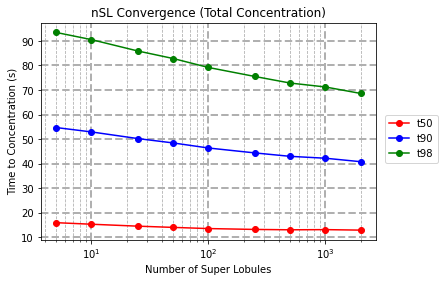

In [4]:
# Make plots of the t50, t90, t98 vs dt
plt.semilogx(nSLs, t50List, 'ro-', label = 't50')
plt.semilogx(nSLs, t90List, 'bo-', label = 't90')
plt.semilogx(nSLs, t98List, 'go-', label = 't98')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Concentration (s)')
plt.title('nSL Convergence (Total Concentration)')
plt.legend(bbox_to_anchor = (1.2, 0.6))
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.show()

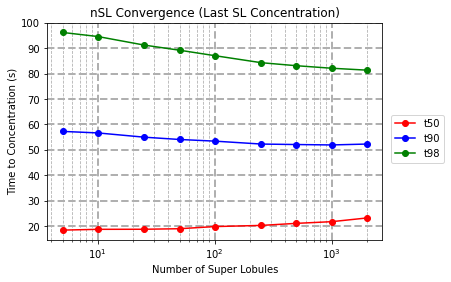

In [5]:
# Make plots of the t50, t90, t98 vs dt
plt.semilogx(nSLs, t50LastList, 'ro-', label = 't50')
plt.semilogx(nSLs, t90LastList, 'bo-', label = 't90')
plt.semilogx(nSLs, t98LastList, 'go-', label = 't98')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Concentration (s)')
plt.title('nSL Convergence (Last SL Concentration)')
plt.legend(bbox_to_anchor=(1.2, 0.6))
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.show()

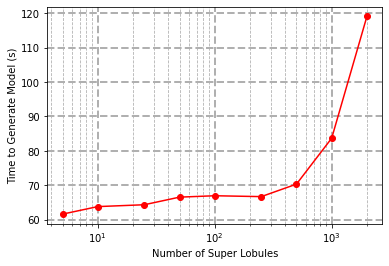

In [6]:
plt.semilogx(nSLs, tSpaceColList, 'ro-')
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Generate Model (s)')

plt.show()

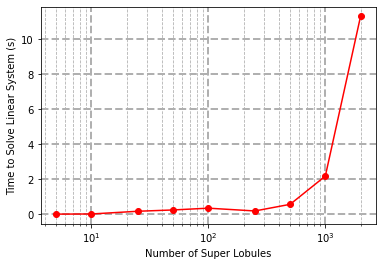

In [8]:
plt.semilogx(nSLs, tMatrixList, 'ro-')
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Solve Linear System (s)')

plt.show()

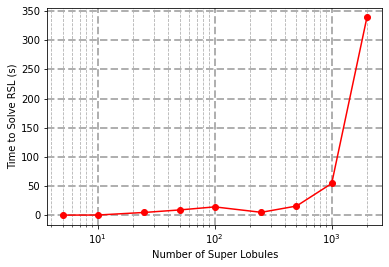

In [9]:
plt.semilogx(nSLs, tRSLList, 'ro-')
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Solve RSL (s)')

plt.show()

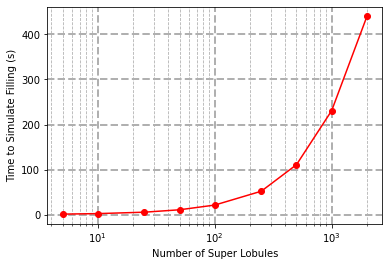

In [10]:
plt.semilogx(nSLs, tFillList, 'ro-')
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Time to Simulate Filling (s)')

plt.show()

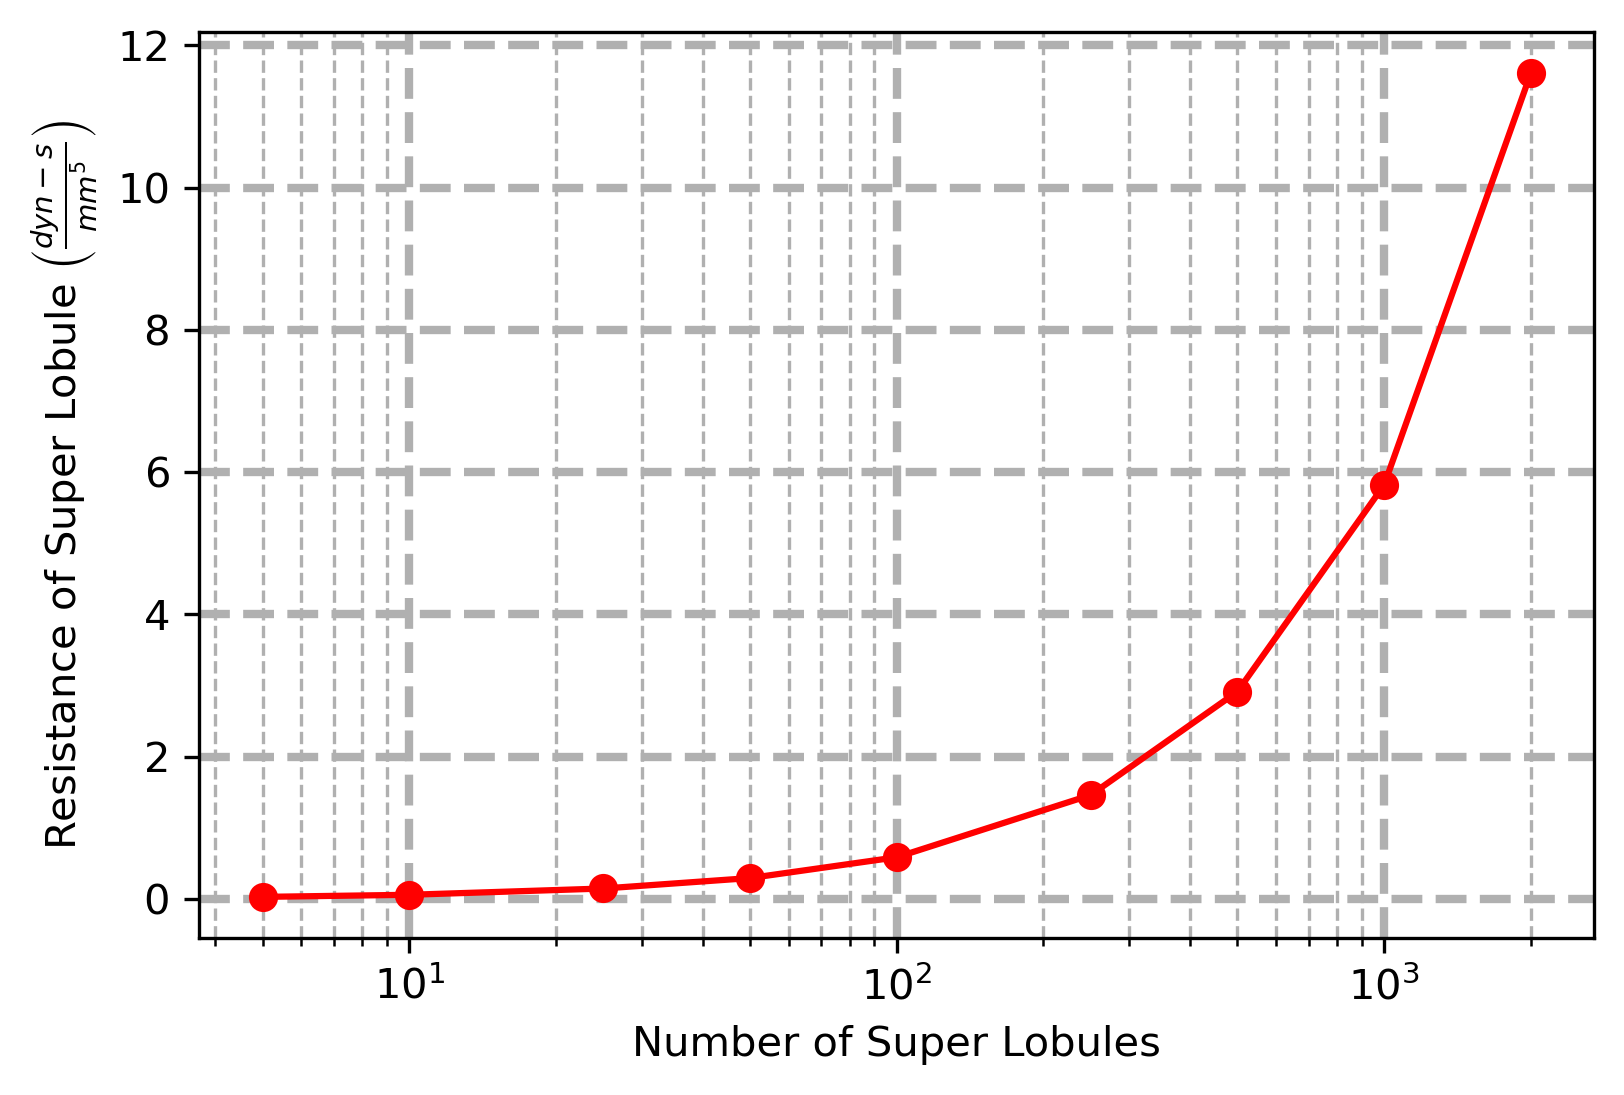

In [38]:
plt.semilogx(nSLs, RSLList, 'ro-')
plt.grid(which = 'major', linestyle = '--', linewidth = 2)
plt.grid(which = 'minor', linestyle = '--')
plt.xlabel('Number of Super Lobules')
plt.ylabel('Resistance of Super Lobule $\left(\\frac{dyn-s}{mm^5}\\right)$')

plt.show()

In [81]:
np.array(deltaPList)/np.array(Qlist)

array([ 0.02971077,  0.05927639,  0.14757895,  0.29435062,  0.58668995,
        1.46142006,  2.91472912,  5.81905365, 11.60700321])

In [17]:
filename = '../results/nSLConvergence/' + str(1000) + 'SL' + '/model.pkl'
with open(filename, 'rb') as handle:
    col = pickle.load(handle)
for sl in col.slList:
    print(sl.getResistance())

5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.819053649902344
5.81905364

In [23]:
1/5.81*1000

172.11703958691913

In [19]:
filename = '../results/nSLConvergence/' + str(10) + 'SL' + '/model.pkl'
with open(filename, 'rb') as handle:
    col = pickle.load(handle)
for sl in col.slList:
    print(sl.getResistance())

0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597
0.059276390075683597


In [5]:
pressures = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
flows = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]